In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install catboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from shapely.geometry import LineString, Point
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from geopy.distance import geodesic
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
import catboost as ctb
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor


In [4]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train = train.drop(train.columns[0], axis=1)
test = test.drop(test.columns[0], axis=1)

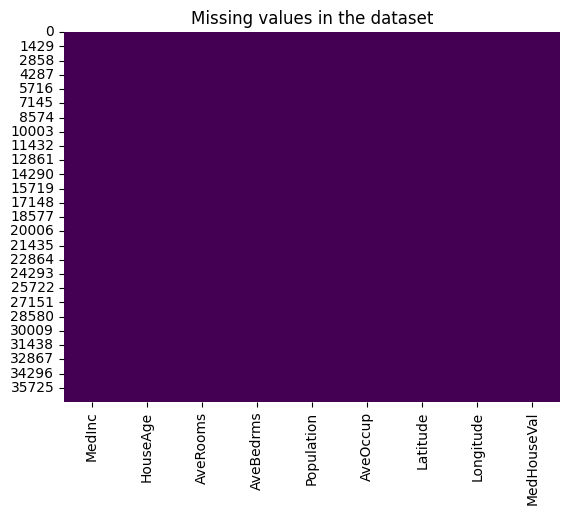

In [5]:
sns.heatmap(train.isnull(),cbar=False,cmap='viridis')
plt.title('Missing values in the dataset')
plt.show()

In [6]:
cate_cols =  train.select_dtypes(include=['object']).columns
for col in cate_cols:
    print(col)
    sns.countplot(x=col,data=train)
    plt.title(f'count plot of {col}')
    plt.show()

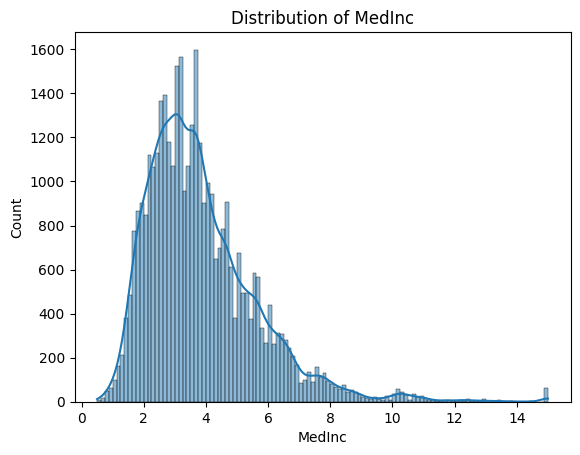

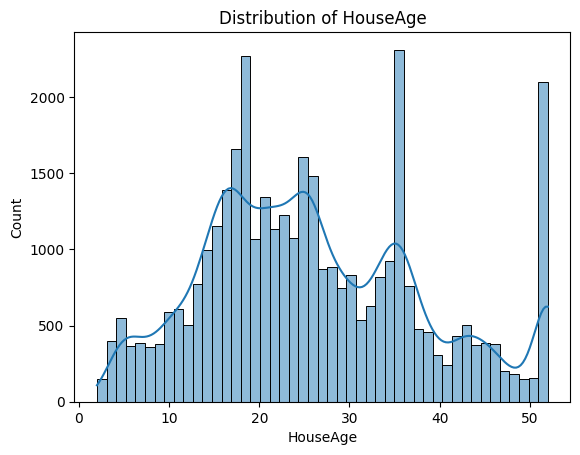

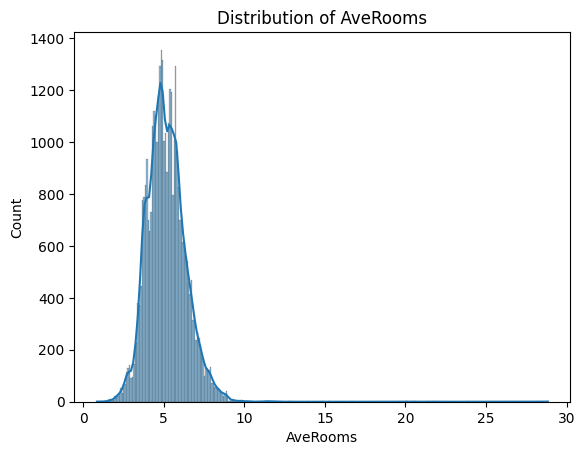

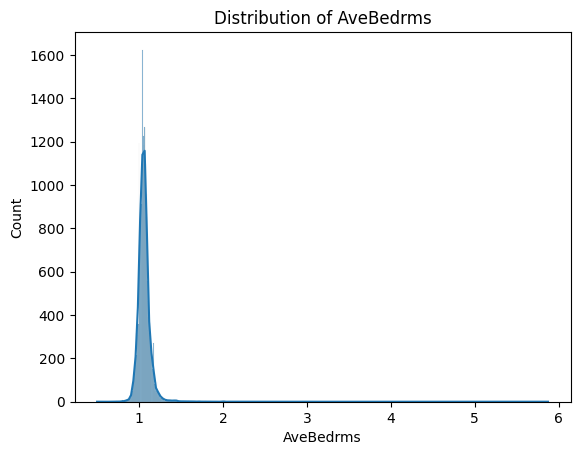

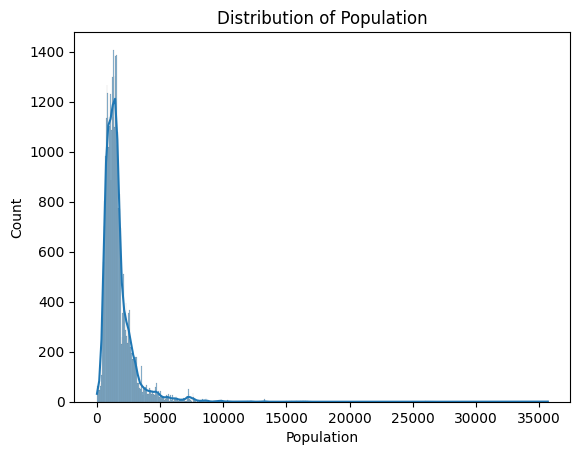

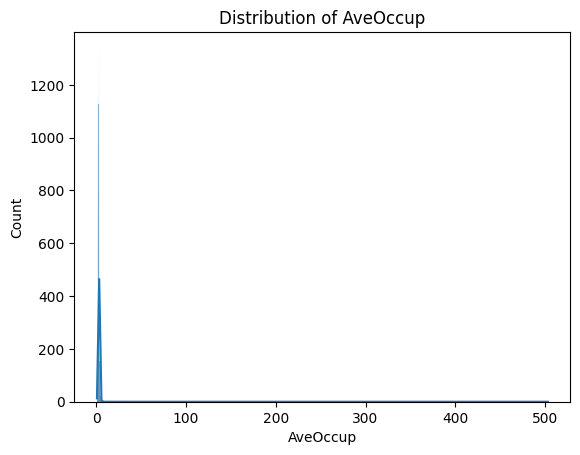

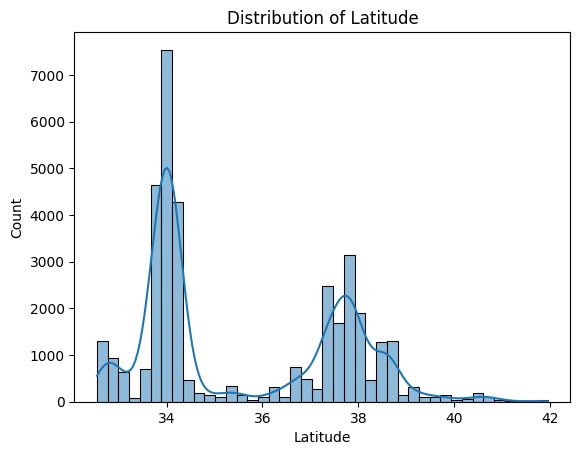

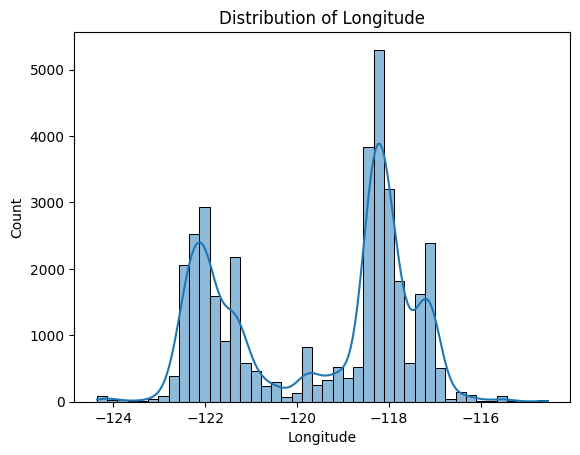

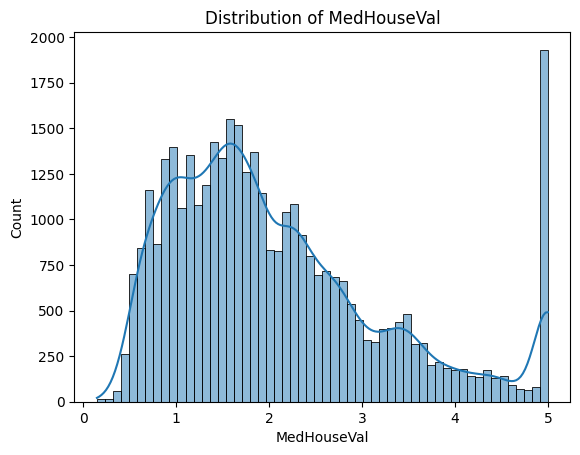

In [7]:
numerical_cols = train.select_dtypes(include=['float64','int64']).columns
for col in numerical_cols:
    sns.histplot(train[col],kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [8]:
X_train = train[['MedInc', 'HouseAge',	'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]
y_train = train['MedHouseVal']

In [9]:
def pca_coords(df):
    coordinates = df[["Latitude", "Longitude"]]

    pca_obj = PCA().fit(coordinates.values)

    df["pca_lat"] = pca_obj.transform(coordinates)[:, 0]
    df["pca_lon"] = pca_obj.transform(coordinates)[:, 1]

    return df

In [10]:
def polar_coords(df):
    df["r"] = np.sqrt(df["Latitude"] ** 2 + df["Longitude"] ** 2)
    df["theta"] = np.arctan2(df["Latitude"], df["Longitude"])
    return df

In [11]:
def rotate_coords(df):
    df["rot_15_x"] = (np.cos(np.radians(15)) * df["Longitude"]) + \
                     (np.sin(np.radians(15)) * df["Latitude"])

    df["rot_15_y"] = (np.cos(np.radians(15)) * df["Latitude"]) - \
                     (np.sin(np.radians(15)) * df["Longitude"])

    df["rot_30_x"] = (np.cos(np.radians(30)) * df["Longitude"]) + \
                     (np.sin(np.radians(30)) * df["Latitude"])

    df["rot_30_y"] = (np.cos(np.radians(30)) * df["Latitude"]) - \
                     (np.sin(np.radians(30)) * df["Longitude"])

    df["rot_45_x"] = (np.cos(np.radians(45)) * df["Longitude"]) + \
                     (np.sin(np.radians(45)) * df["Latitude"])

    df["rot_45_y"] = (np.cos(np.radians(45)) * df["Latitude"]) - \
                     (np.sin(np.radians(45)) * df["Longitude"])
    return df

In [12]:
# Функция для вычисления расстояния до ближайшего города
def distance_to_nearest_city(lat, lon, cities):
    distances = {city: geodesic((lat, lon), city_coords).km for city, city_coords in cities.items()}
    return min(distances.values())

In [13]:
# Функция для вычисления расстояния до заданного города
def calculate_distance(row, city_coords):
    return geodesic((row['Latitude'], row['Longitude']), city_coords).kilometers

In [14]:
def add_city_dist(data):
    # Координаты топ5 крупных городов Калифорнии
    cities = {
    'Los_Angeles': (34.05, -118.24),
    'San_Francisco': (37.77, -122.41),
    'San_Diego': (32.71, -117.16),
    'San_hose': (37.33, -121.89),
    'Fresno': (36.74, -119.77)
    }
    #Столбец расстояний до ближайшего крупного
    data['distance_to_nearest'] = data.apply(lambda row: distance_to_nearest_city(
                                                                row['Latitude'],
                                                                row['Longitude'],
                                                                cities), axis=1)
    # Добавляем столбец расстояния до каждого крупного города
    for city, coords in cities.items():
        col_name = f'distance_to_{city}'
        data[col_name] = data.apply(lambda row: calculate_distance(row, coords), axis=1)

    return data

In [15]:
def add_log_feature(data, column):
    data[f"log_{column}"] = np.log1p(data[column])

In [16]:
X_train = add_city_dist(X_train)
X_train = rotate_coords(X_train)
X_train = polar_coords(X_train)
X_train = pca_coords(X_train)

test = add_city_dist(test)
test = rotate_coords(test)
test = polar_coords(test)
test = pca_coords(test)

features_to_process = ["AveOccup", "Population", "AveBedrms"]
for feature in features_to_process:
    add_log_feature(X_train, feature)
    add_log_feature(test, feature)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


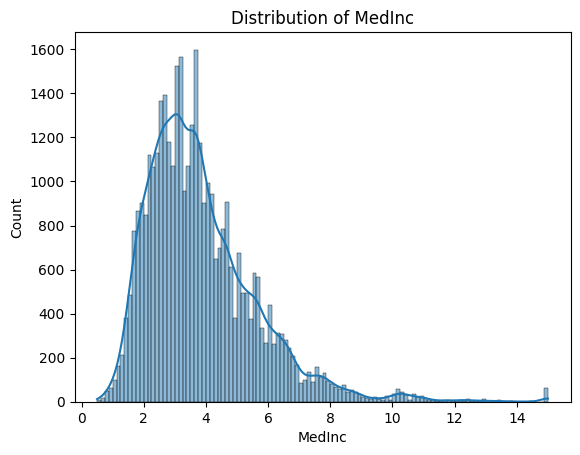

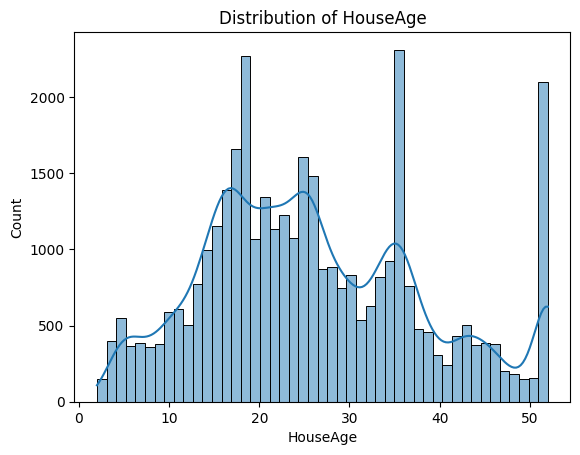

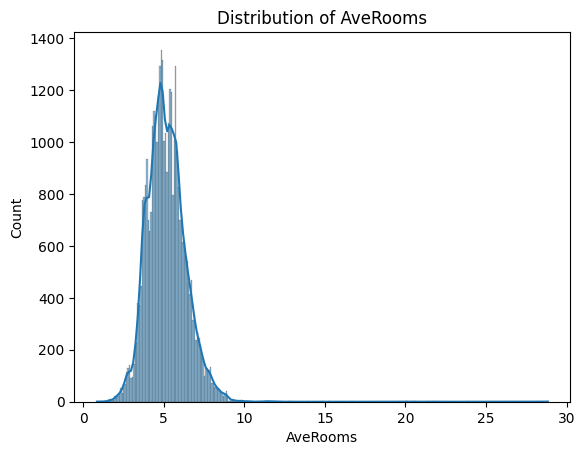

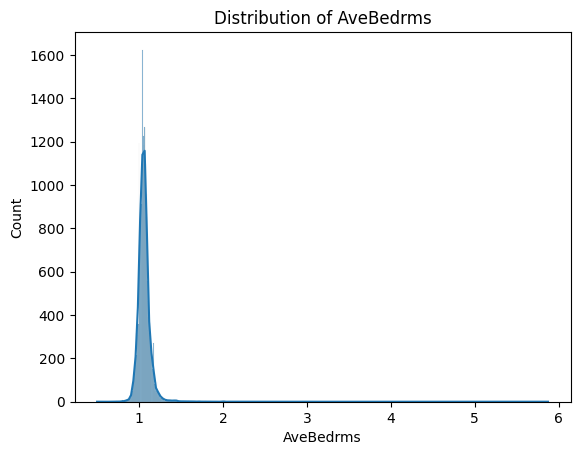

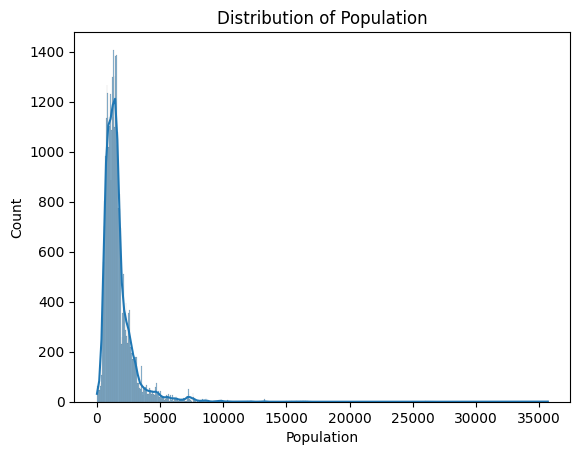

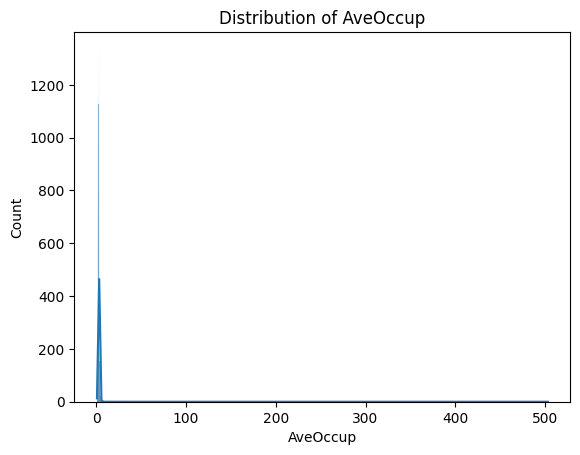

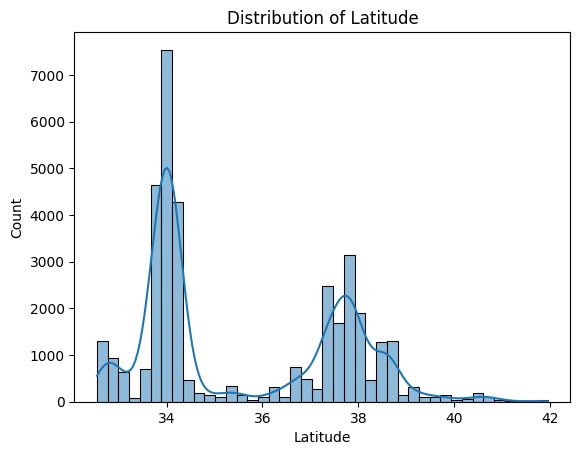

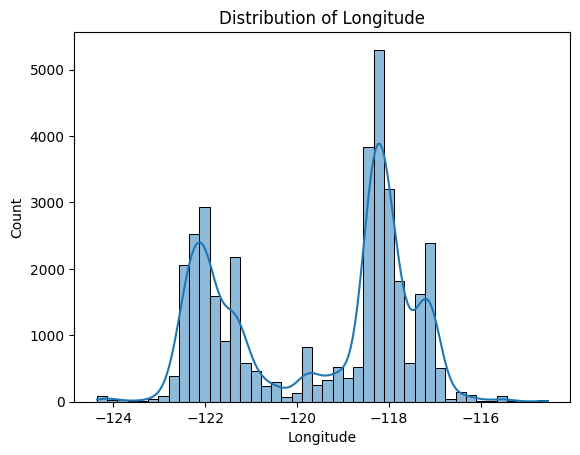

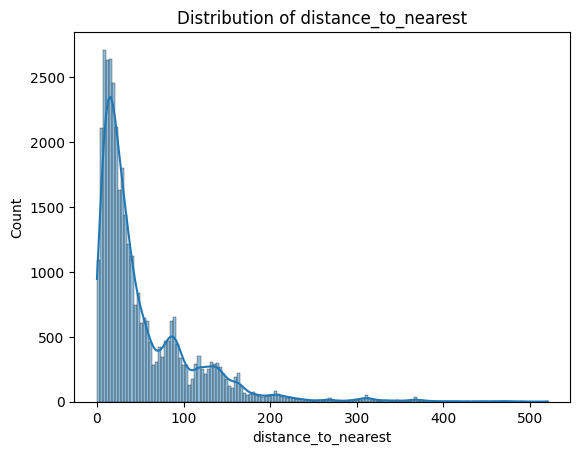

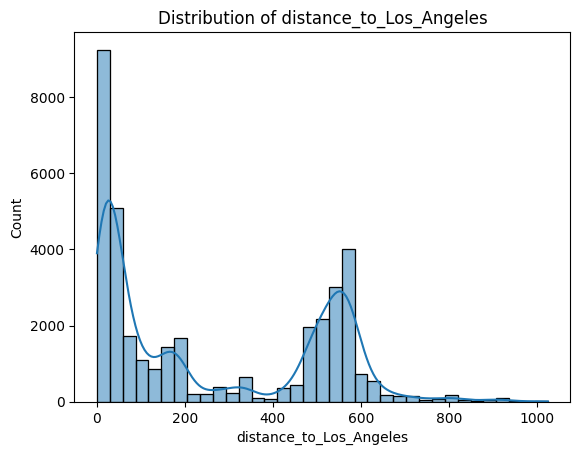

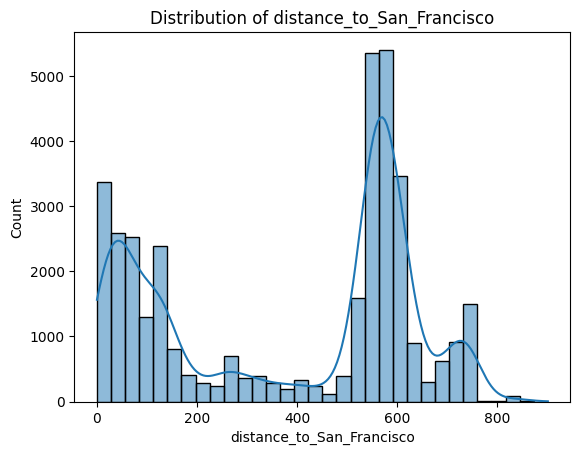

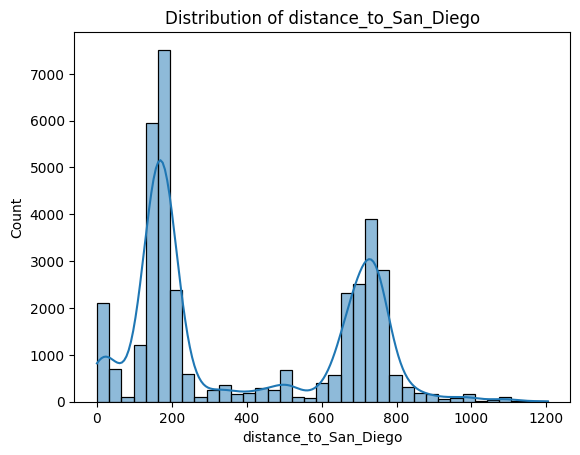

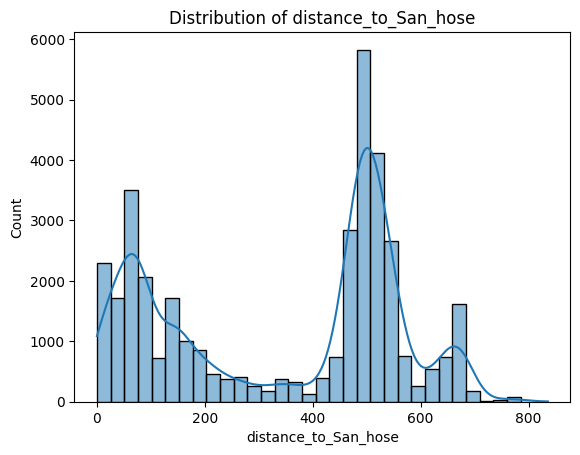

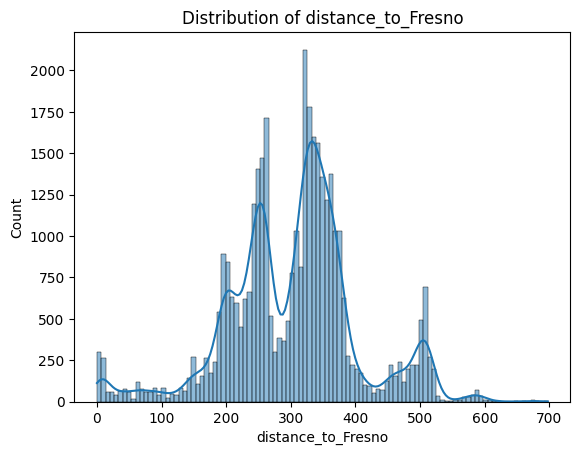

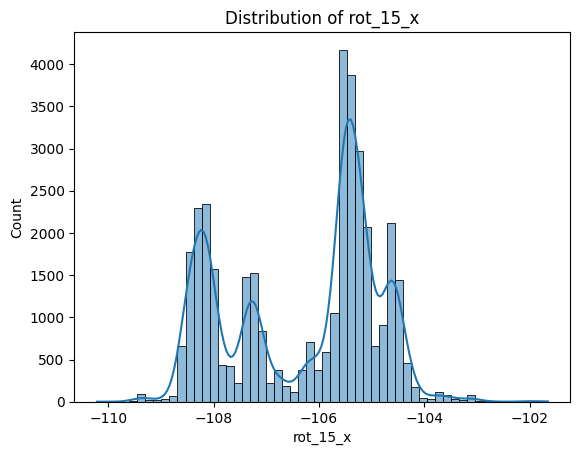

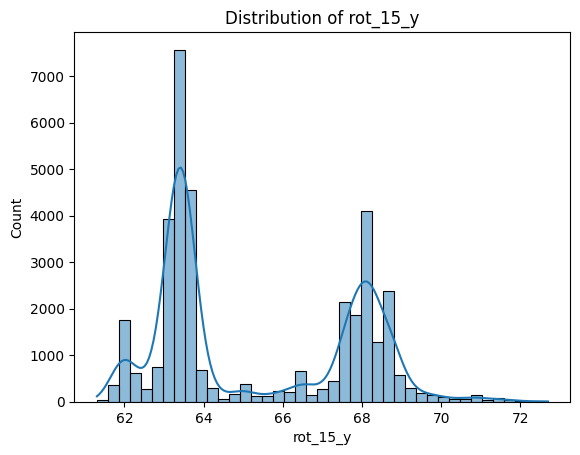

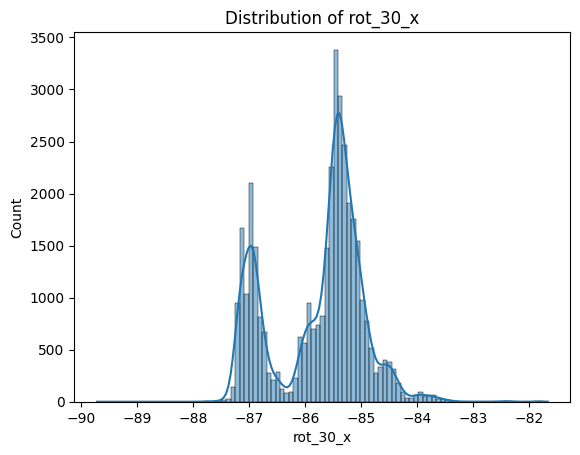

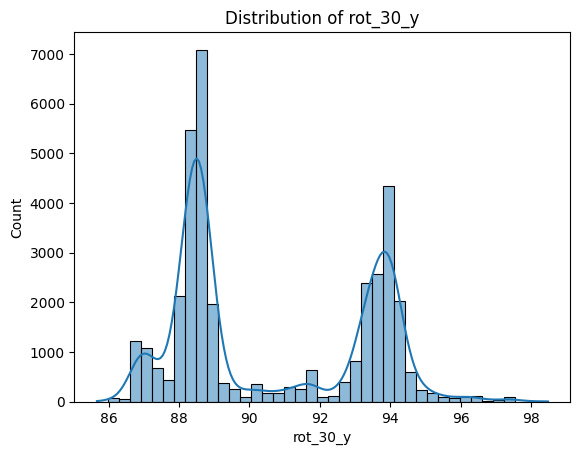

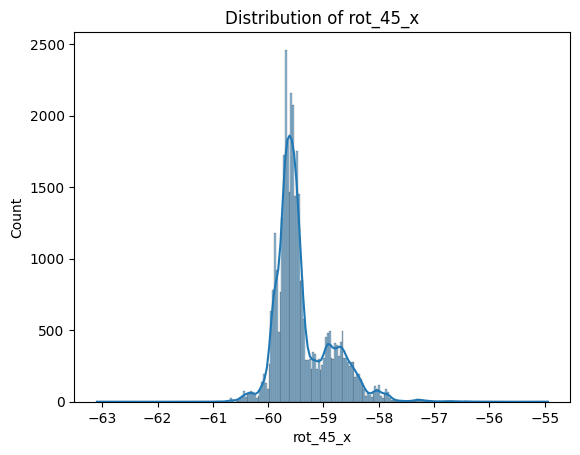

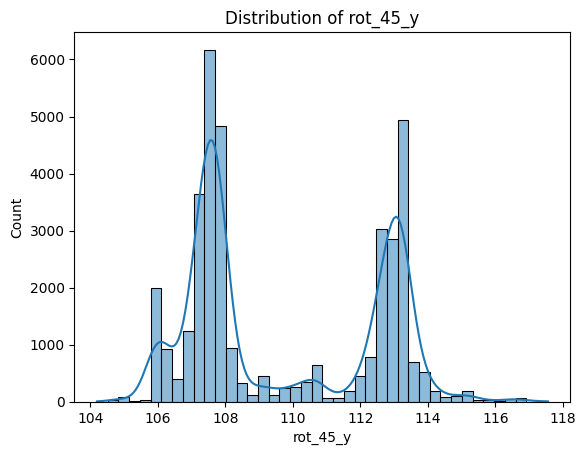

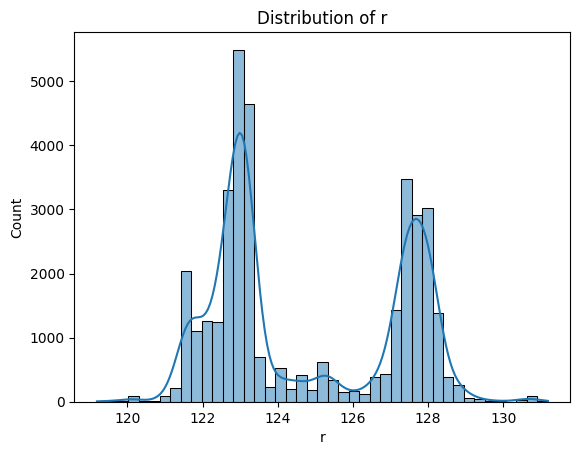

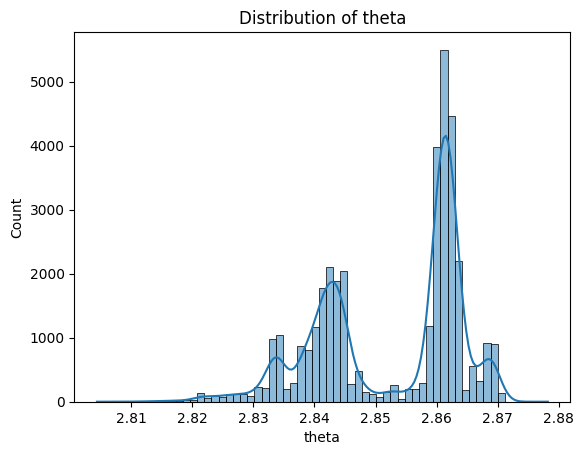

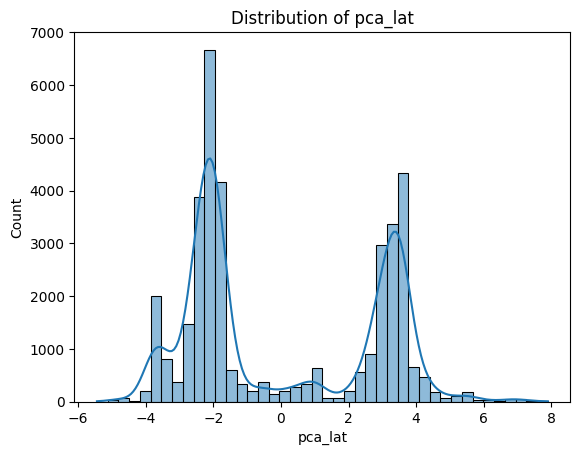

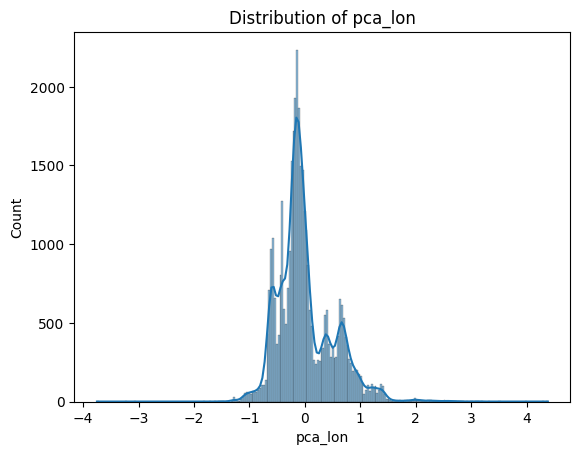

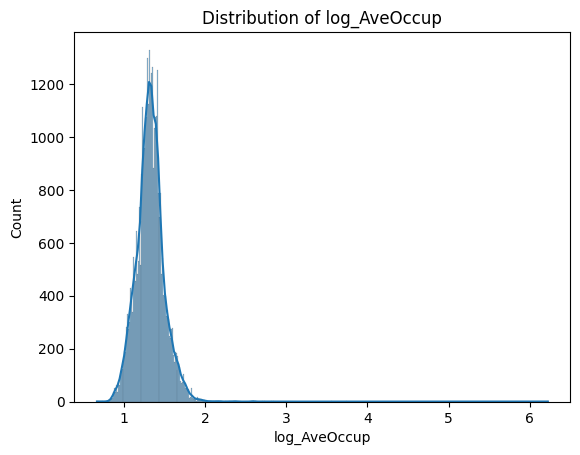

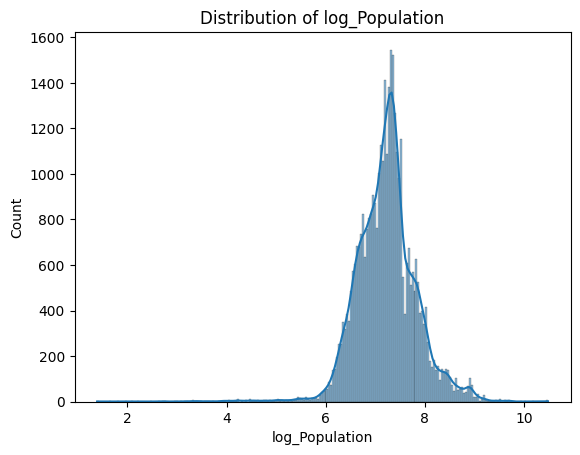

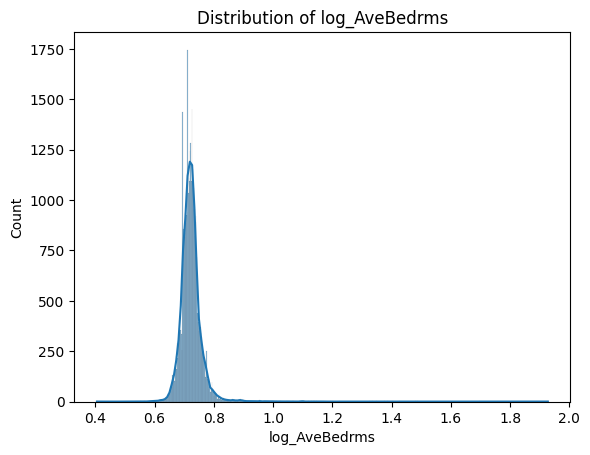

In [17]:
numerical_cols = X_train.select_dtypes(include=['float64','int64']).columns
for col in numerical_cols:
    sns.histplot(X_train[col],kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [18]:
emb_size = 20
precision = 1e6

coordinates = X_train[['Latitude', 'Longitude']].values
latlon = np.expand_dims(coordinates, axis=-1)

m = np.exp(np.log(precision) / emb_size)
angle_freq = m ** np.arange(emb_size)
angle_freq = angle_freq.reshape(1, 1, emb_size)

latlon = latlon * angle_freq
latlon[..., 0::2] = np.cos(latlon[..., 0::2])
latlon[..., 1::2] = np.sin(latlon[..., 1::2])
latlon = latlon.reshape(-1, 2 * emb_size)

X_train['exp_latlon1'] = [lat[0] for lat in latlon]
X_train['exp_latlon2'] = [lat[1] for lat in latlon]

In [19]:
coordinates_test = test[['Latitude', 'Longitude']].values
latlon_test = np.expand_dims(coordinates_test, axis=-1)

m_test = np.exp(np.log(precision) / emb_size)
angle_freq_test = m ** np.arange(emb_size)
angle_freq_test = angle_freq_test.reshape(1, 1, emb_size)

latlon_test = latlon_test * angle_freq_test
latlon_test[..., 0::2] = np.cos(latlon_test[..., 0::2])
latlon_test[..., 1::2] = np.sin(latlon_test[..., 1::2])
latlon_test = latlon_test.reshape(-1, 2 * emb_size)

test['exp_latlon1'] = [lat[0] for lat in latlon_test]
test['exp_latlon2'] = [lat[1] for lat in latlon_test]

In [20]:
coast_points = LineString([(32.664, -117.161), (33.206, -117.383),
                           (33.777, -118.202), (34.463, -120.014),
                           (35.427, -120.881), (35.928, -121.489),
                           (36.982, -122.028), (37.611, -122.491),
                           (38.355, -123.060), (39.792, -123.821),
                           (40.799, -124.188), (41.755, -124.197)])
X_train['dist_to_coast'] = X_train.apply(lambda x: Point(x['Latitude'], x['Longitude']).distance(coast_points), axis=1)
test['dist_to_coast'] = test.apply(lambda x: Point(x['Latitude'], x['Longitude']).distance(coast_points), axis=1)


In [21]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)

In [23]:
X_train,X_val,y_train,y_val=train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [24]:
X_train.shape

(29709, 30)

In [25]:
y_train.shape

(29709,)

In [26]:
test = scaler.fit_transform(test)
test = pd.DataFrame(test, columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'distance_to_nearest', 'distance_to_Los_Angeles', 'distance_to_San_Francisco', 'distance_to_San_Diego', 'distance_to_San_hose', 'distance_to_Fresno', 'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y', 'r', 'theta', 'pca_lat', 'pca_lon', 'log_AveOccup', 'log_Population', 'log_AveBedrms', 'exp_latlon1', 'exp_latlon2', 'dist_to_coast'])

df_xtrain = pd.DataFrame(X_train, columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'distance_to_nearest', 'distance_to_Los_Angeles', 'distance_to_San_Francisco', 'distance_to_San_Diego', 'distance_to_San_hose', 'distance_to_Fresno', 'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y', 'r', 'theta', 'pca_lat', 'pca_lon', 'log_AveOccup', 'log_Population', 'log_AveBedrms', 'exp_latlon1', 'exp_latlon2', 'dist_to_coast'])
df_xval = pd.DataFrame(X_val, columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'distance_to_nearest', 'distance_to_Los_Angeles', 'distance_to_San_Francisco', 'distance_to_San_Diego', 'distance_to_San_hose', 'distance_to_Fresno', 'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y', 'r', 'theta', 'pca_lat', 'pca_lon', 'log_AveOccup', 'log_Population', 'log_AveBedrms', 'exp_latlon1', 'exp_latlon2', 'dist_to_coast'])
df_ytrain = pd.Series(y_train, name='MedHouseVal')
df_yval = pd.Series(y_val, name='MedHouseVal')

X = pd.concat([df_xtrain, df_xval])
y = pd.concat([df_ytrain, df_yval])

Ниже пробую разные подходы и с разным составом ансамблей

In [28]:
# Настройки для Random Forest
rf_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'n_jobs': -1,
     'max_features': 'sqrt'
}

skf = KFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)
skf.get_n_splits(X, y)

rf_scores = []
rf_r2_scores = []
rf_mae_scores = []
rf_models = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    train_x = X.iloc[train_index]
    train_y = y.iloc[train_index]
    valid_x = X.iloc[test_index]
    valid_y = y.iloc[test_index]

    rf_model = RandomForestRegressor(**rf_params)

    rf_model.fit(train_x, train_y)

    val_preds = rf_model.predict(valid_x)

    val_rmse = mean_squared_error(valid_y, val_preds, squared=False)
    val_r2 = r2_score(valid_y, val_preds)
    val_mae = mean_absolute_error(valid_y, val_preds)

    rf_scores.append(val_rmse)
    rf_r2_scores.append(val_r2)
    rf_mae_scores.append(val_mae)
    rf_models.append(rf_model)

    print(f"RMSE: {val_rmse}, R2: {val_r2}, MAE: {val_mae}")
    print("-" * 10)

print(f"Mean RMSE: {np.mean(rf_scores)}, Mean R2: {np.mean(rf_r2_scores)}, Mean MAE: {np.mean(rf_mae_scores)}")


RMSE: 0.5629163379533673, R2: 0.760683104358429, MAE: 0.40921187581265783
----------
RMSE: 0.5692106850436298, R2: 0.7540085555580129, MAE: 0.40434945072570444
----------
RMSE: 0.5691260357714103, R2: 0.7547389124249594, MAE: 0.40545194954163044
----------
RMSE: 0.5908349971994866, R2: 0.7414092302802076, MAE: 0.4227124123939625
----------
RMSE: 0.5995903740682029, R2: 0.7341350470029914, MAE: 0.4272830022121419
----------
RMSE: 0.5801896595846753, R2: 0.7531197969645533, MAE: 0.40973061354236795
----------
RMSE: 0.5848794298194331, R2: 0.7477732061312545, MAE: 0.4172975905435758
----------
RMSE: 0.5620530883263476, R2: 0.7661946378305989, MAE: 0.4058071440660176
----------
RMSE: 0.5812878671796875, R2: 0.7509510584632864, MAE: 0.4163356380412465
----------
RMSE: 0.5901722912084285, R2: 0.7380045418919716, MAE: 0.41922831289573115
----------
Mean RMSE: 0.5790260766154669, Mean R2: 0.7501018090906265, Mean MAE: 0.41374079897750365


In [27]:
xgb_params = {
        'max_depth': 9,
        'eta': 0.01,
        'colsample_bytree': 0.66,
        'subsample': 0.76,
        'min_child_weight': 22,
        'lambda': 16,
        'gamma': 1,

        'tree_method': 'hist',
        'booster': 'gbtree',
        'predictor':'cpu_predictor',
        'seed': 42,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }

In [30]:
lgbm_params = {
        'n_estimators': 1000,
        'reg_lambda': 0.8435272531761764,
        'reg_alpha': 0.0047770992003183695,
        'colsample_bytree': 0.5,
        'learning_rate': 0.01,
        'subsample': 0.8,
        'max_depth': 100,
        'min_child_samples': 194,
        'num_leaves': 894
}

skf = KFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)
skf.get_n_splits(X, y)
lgbm_model = LGBMRegressor(**lgbm_params)


lgbm_scores = []
lgbm_models = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    train_x = X.iloc[train_index]
    train_y = y.iloc[train_index]
    valid_x = X.iloc[test_index]
    valid_y = y.iloc[test_index]

    lgbm_model = LGBMRegressor(**lgbm_params)
    lgbm_model.fit(X=train_x,
                   y=train_y,
                   eval_set=[(valid_x, valid_y)])
    lgbm_models.append(lgbm_model)
    val_preds = lgbm_model.predict(valid_x)
    val_score = mean_squared_error(valid_y, val_preds, squared=False)
    lgbm_scores.append(val_score)

    print(f"RMSE: {val_score}")
    print("-" * 10)

# Печать средних результатов
print(f"Mean RMSE: {np.mean(lgbm_scores)}")

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [41]:
best_lgbm = lgbm_models[np.argmin(lgbm_scores)]

In [43]:
columns = ["id"] + ["MedHouseVal"]
df_ctbsolution = pd.DataFrame(columns=columns)
df_ctbsolution['id'] = range(37137, len(test) + 37137)
df_ctbsolution['MedHouseVal'] = best_lgbm.predict(test)
df_ctbsolution.to_csv('lgbmsolution_posencode.csv',index=False)

In [31]:
skf = KFold(
    n_splits = 10,
    random_state = 1,
    shuffle = True
)
skf.get_n_splits(X, y)

xgb_scores = []
xgb_models = []
for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    valid_x = X.iloc[val_index]
    valid_y = y.iloc[val_index]

    xgb_train = xgb.DMatrix(
        X.iloc[train_index],
        label = y.iloc[train_index],
    )

    xgb_valid = xgb.DMatrix(
        valid_x,
        label = valid_y,
    )

    watchlist = [(xgb_train, "train"), (xgb_valid, "val")]

    xgb_model = xgb.train(
        params = xgb_params,
        dtrain = xgb_train,
        num_boost_round = 50000,
        evals = watchlist,
        verbose_eval = 1000,
        callbacks = [
            xgb.callback.EarlyStopping(
                rounds = 1000,
                data_name = "val",
                maximize = False,
                save_best = True
            )
        ]
    )

    val_preds = xgb_model.predict(xgb_valid)
    val_score = mean_squared_error(
        valid_y,
        val_preds,
        squared = False
    )

    xgb_scores.append(val_score)
    xgb_models.append(xgb_model)

    print(f"RMSE: {val_score}")
    print("-" * 50)

[0]	train-rmse:1.15135	val-rmse:1.14302


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:35:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.47757	val-rmse:0.54550
[2000]	train-rmse:0.46931	val-rmse:0.54551
[2091]	train-rmse:0.46897	val-rmse:0.54556
RMSE: 0.5454261234574304
--------------------------------------------------
[0]	train-rmse:1.15173	val-rmse:1.13966


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:35:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.47695	val-rmse:0.55180
[2000]	train-rmse:0.46975	val-rmse:0.55175
[3000]	train-rmse:0.46605	val-rmse:0.55173
[3878]	train-rmse:0.46391	val-rmse:0.55177
RMSE: 0.5516244025510998
--------------------------------------------------
[0]	train-rmse:1.15149	val-rmse:1.14113


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:36:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.47725	val-rmse:0.54740
[2000]	train-rmse:0.46997	val-rmse:0.54718
[3000]	train-rmse:0.46692	val-rmse:0.54710
[4000]	train-rmse:0.46456	val-rmse:0.54705
[5000]	train-rmse:0.46282	val-rmse:0.54696
[6000]	train-rmse:0.46098	val-rmse:0.54698
[6497]	train-rmse:0.46016	val-rmse:0.54702
RMSE: 0.5468789554486296
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:37:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1.15008	val-rmse:1.15416
[1000]	train-rmse:0.47521	val-rmse:0.56757
[2000]	train-rmse:0.46803	val-rmse:0.56719
[3000]	train-rmse:0.46445	val-rmse:0.56690
[4000]	train-rmse:0.46138	val-rmse:0.56690
[4393]	train-rmse:0.46064	val-rmse:0.56690
RMSE: 0.5668349916403937
--------------------------------------------------
[0]	train-rmse:1.15000	val-rmse:1.15508


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:37:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.47648	val-rmse:0.56379
[2000]	train-rmse:0.46871	val-rmse:0.56280
[3000]	train-rmse:0.46516	val-rmse:0.56234
[4000]	train-rmse:0.46268	val-rmse:0.56216
[5000]	train-rmse:0.46095	val-rmse:0.56213
[6000]	train-rmse:0.45940	val-rmse:0.56193
[7000]	train-rmse:0.45815	val-rmse:0.56178
[8000]	train-rmse:0.45710	val-rmse:0.56172
[9000]	train-rmse:0.45614	val-rmse:0.56169
[10000]	train-rmse:0.45512	val-rmse:0.56161
[11000]	train-rmse:0.45442	val-rmse:0.56157
[12000]	train-rmse:0.45364	val-rmse:0.56151
[12475]	train-rmse:0.45341	val-rmse:0.56150
RMSE: 0.5615003113232372
--------------------------------------------------
[0]	train-rmse:1.14951	val-rmse:1.15992


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:38:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.47705	val-rmse:0.56049
[2000]	train-rmse:0.46933	val-rmse:0.56011
[3000]	train-rmse:0.46550	val-rmse:0.55987
[4000]	train-rmse:0.46313	val-rmse:0.55977
[5000]	train-rmse:0.46133	val-rmse:0.55972
[6000]	train-rmse:0.45997	val-rmse:0.55978
[6451]	train-rmse:0.45939	val-rmse:0.55987
RMSE: 0.5597125277444441
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:39:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1.14982	val-rmse:1.15678
[1000]	train-rmse:0.47602	val-rmse:0.55748
[2000]	train-rmse:0.46818	val-rmse:0.55704
[3000]	train-rmse:0.46483	val-rmse:0.55694
[4000]	train-rmse:0.46242	val-rmse:0.55693
[4065]	train-rmse:0.46232	val-rmse:0.55692
RMSE: 0.5569109616982283
--------------------------------------------------
[0]	train-rmse:1.15012	val-rmse:1.15427


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:40:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.47810	val-rmse:0.53373
[2000]	train-rmse:0.47078	val-rmse:0.53344
[3000]	train-rmse:0.46751	val-rmse:0.53353
[3012]	train-rmse:0.46750	val-rmse:0.53352
RMSE: 0.5334312673413075
--------------------------------------------------
[0]	train-rmse:1.14980	val-rmse:1.15695


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:40:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.47581	val-rmse:0.56722
[2000]	train-rmse:0.46844	val-rmse:0.56670
[3000]	train-rmse:0.46457	val-rmse:0.56655
[4000]	train-rmse:0.46236	val-rmse:0.56639
[5000]	train-rmse:0.46031	val-rmse:0.56648
[5190]	train-rmse:0.45997	val-rmse:0.56651
RMSE: 0.5663702415555881
--------------------------------------------------
[0]	train-rmse:1.15108	val-rmse:1.14522


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:41:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	train-rmse:0.47529	val-rmse:0.56676
[2000]	train-rmse:0.46805	val-rmse:0.56606
[3000]	train-rmse:0.46457	val-rmse:0.56586
[4000]	train-rmse:0.46192	val-rmse:0.56559
[5000]	train-rmse:0.46025	val-rmse:0.56549
[6000]	train-rmse:0.45890	val-rmse:0.56546
[7000]	train-rmse:0.45779	val-rmse:0.56543
[8000]	train-rmse:0.45696	val-rmse:0.56536
[9000]	train-rmse:0.45596	val-rmse:0.56529
[10000]	train-rmse:0.45502	val-rmse:0.56523
[11000]	train-rmse:0.45430	val-rmse:0.56510
[12000]	train-rmse:0.45361	val-rmse:0.56506
[13000]	train-rmse:0.45307	val-rmse:0.56509
[13004]	train-rmse:0.45307	val-rmse:0.56509
RMSE: 0.5650620118682501
--------------------------------------------------


In [50]:
best_xgb = xgb_models[np.argmin(xgb_scores)]

In [30]:
best_rf = rf_models[np.argmin(rf_scores)]

In [33]:
ctb_params = {
      "random_seed": 42,
      "iterations": 15000,
      "early_stopping_rounds": 1000,
      "use_best_model": True,
      "eval_metric": 'RMSE',
      "verbose": 1000
}

skf = KFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)
skf.get_n_splits(X, y)

ctb_scores = []
ctb_models = []
ctb_r2 = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    train_x = X.iloc[train_index]
    train_y = y.iloc[train_index]
    valid_x = X.iloc[test_index]
    valid_y = y.iloc[test_index]

    pooling_train = ctb.Pool(data=train_x, label=train_y)
    pooling_valid = ctb.Pool(data=valid_x, label=valid_y)

    ctb_model = ctb.CatBoostRegressor(**ctb_params)

    ctb_model.fit(pooling_train, eval_set=pooling_valid)

    val_preds = ctb_model.predict(pooling_valid)

    val_score = mean_squared_error(valid_y, val_preds, squared=False)
    val_r2 = ctb_model.score(pooling_valid)

    ctb_scores.append(val_score)
    ctb_models.append(ctb_model)
    ctb_r2.append(val_r2)

    print(f"RMSE: {val_score}, R2: {val_r2}")
    print("-" * 10)

# Печать средних результатов
print(f"Mean RMSE: {np.mean(ctb_scores)}, Mean R2: {np.mean(ctb_r2)}")

Learning rate set to 0.016934
0:	learn: 1.1474764	test: 1.1389499	best: 1.1389499 (0)	total: 23.8ms	remaining: 5m 57s
1000:	learn: 0.5435123	test: 0.5539455	best: 0.5539386 (997)	total: 15.3s	remaining: 3m 34s
2000:	learn: 0.5163758	test: 0.5494040	best: 0.5493778 (1995)	total: 31.9s	remaining: 3m 27s
3000:	learn: 0.4970417	test: 0.5479753	best: 0.5479744 (2998)	total: 47.1s	remaining: 3m 8s
4000:	learn: 0.4804811	test: 0.5478750	best: 0.5476194 (3862)	total: 1m 2s	remaining: 2m 50s
5000:	learn: 0.4657766	test: 0.5474453	best: 0.5474367 (4998)	total: 1m 17s	remaining: 2m 34s
6000:	learn: 0.4525276	test: 0.5475240	best: 0.5473232 (5354)	total: 1m 32s	remaining: 2m 18s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5473231674
bestIteration = 5354

Shrink model to first 5355 iterations.
RMSE: 0.5473231666134419, R2: 0.7737579563280541
----------
Learning rate set to 0.016934
0:	learn: 1.1476933	test: 1.1355492	best: 1.1355492 (0)	total: 40.8ms	remaining: 10m 12s
100

In [37]:
best_ctb = ctb_models[np.argmin(ctb_scores)]

In [34]:
predictions = []
xgb_test = xgb.DMatrix(test)

xgb_predictions = []
for model in xgb_models:
    pred = model.predict(xgb_test)
    xgb_predictions.append(pred)

predictions.append(np.mean(xgb_predictions, axis = 0))

In [34]:
rf_predictions = []
for model in rf_models:
    pred = model.predict(test)
    rf_predictions.append(pred)

predictions.append(np.mean(rf_predictions, axis = 0))

In [35]:
catboost_predictions = []
for model in ctb_models:
    pred = model.predict(test)
    catboost_predictions.append(pred)

predictions.append(np.mean(catboost_predictions, axis = 0))

In [36]:
lgbm_predictions = []
for model in lgbm_models:
    pred = model.predict(test)
    lgbm_predictions.append(pred)

predictions.append(np.mean(lgbm_predictions, axis = 0))

In [37]:
columns = ["id"] + ["MedHouseVal"]
df_solution = pd.DataFrame(columns=columns)
df_solution['id'] = range(37137, len(test) + 37137)
df_solution['MedHouseVal'] = np.mean(predictions, axis = 0)
df_solution.to_csv('meansolve_posencod_coastpoints.csv',index=False)

In [33]:
columns = ["id"] + ["MedHouseVal"]
df_solution = pd.DataFrame(columns=columns)
df_solution['id'] = range(37137, len(test) + 37137)
df_solution['MedHouseVal'] = best_rf.predict(test)
df_solution.to_csv('baselinetry3.csv',index=False)

In [51]:
df_xgbsolution = pd.DataFrame(columns=columns)
df_xgbsolution['id'] = range(37137, len(test) + 37137)
xgb_test = xgb.DMatrix(test)
df_xgbsolution['MedHouseVal'] = best_xgb.predict(xgb_test)
df_xgbsolution.to_csv('best_xgbsolution_coastpoints_posencod.csv',index=False)

In [48]:
df_ctbsolution = pd.DataFrame(columns=columns)
df_ctbsolution['id'] = range(37137, len(test) + 37137)
ctb_test = ctb.Pool(data=test)
df_ctbsolution['MedHouseVal'] = ctb_model.predict(ctb_test)
df_ctbsolution.to_csv('ctbsolution.csv',index=False)

In [40]:
ctb_test = ctb.Pool(data=test)

rf_params = {
    'n_estimators': 100,
    'max_depth': None,
    'random_state': 1,
}

xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'random_state': 1,
}

catboost_params = {
    'iterations': 100,
    'depth': 6,
    'learning_rate': 0.1,
    'random_seed': 1,
    'logging_level': 'Silent',
}

rf_model = RandomForestRegressor(**rf_params)
xgb_model = xgb.XGBRegressor(**xgb_params)
catboost_model = ctb.CatBoostRegressor(**catboost_params)

skf = KFold(
    n_splits=5,
    random_state=1,
    shuffle=True
)

meta_features = []
meta_targets = []

test_meta_features = []

for train_index, val_index in skf.split(X, y):
    train_x, val_x = X.iloc[train_index], X.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    rf_model.fit(train_x, train_y)
    rf_preds = rf_model.predict(val_x)

    xgb_model.fit(train_x, train_y)
    xgb_preds = xgb_model.predict(val_x)

    # pooling_train = ctb.Pool(data=train_x, label=train_y)
    # pooling_valid = ctb.Pool(data=valid_x, label=valid_y)
    catboost_model.fit(train_x, train_y)
    catboost_preds = catboost_model.predict(val_x)

    print(f"ctb_preds_shape: {catboost_preds.shape}, xgb_preds_shape: {xgb_preds.shape}, rf_preds_shape: {rf_preds.shape}")
    meta_features.append(np.column_stack([rf_preds, xgb_preds, catboost_preds]))
    meta_targets.append(val_y)

    rf_test_preds = rf_model.predict(test)
    xgb_test_preds = xgb_model.predict(test)
    catboost_test_preds = catboost_model.predict(ctb_test)

    test_meta_features.append(np.column_stack([rf_test_preds, xgb_test_preds, catboost_test_preds]))

meta_features = np.vstack(meta_features)
meta_targets = np.concatenate(meta_targets)
test_meta_features = np.mean(test_meta_features, axis=0)

poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge(alpha=0.00078))
])

poly_model.fit(meta_features, meta_targets)

final_preds = poly_model.predict(test_meta_features)

final_preds

ctb_preds_shape: (7428,), xgb_preds_shape: (7428,), rf_preds_shape: (7428,)
ctb_preds_shape: (7428,), xgb_preds_shape: (7428,), rf_preds_shape: (7428,)
ctb_preds_shape: (7427,), xgb_preds_shape: (7427,), rf_preds_shape: (7427,)
ctb_preds_shape: (7427,), xgb_preds_shape: (7427,), rf_preds_shape: (7427,)
ctb_preds_shape: (7427,), xgb_preds_shape: (7427,), rf_preds_shape: (7427,)


array([0.63916723, 0.96794637, 4.08511844, ..., 1.1409503 , 3.91921167,
       3.74966159])

In [55]:
columns = ["id"] + ["MedHouseVal"]
df_meta_solution = pd.DataFrame(columns=columns)
df_meta_solution['id'] = range(37137, len(test) + 37137)
df_meta_solution['MedHouseVal'] = final_preds
df_meta_solution.to_csv('metapreds.csv',index=False)

In [62]:
ctb_test = ctb.Pool(data=test)

rf_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'n_jobs': -1,
     'max_features': 'sqrt'
}

xgb_params = {
        'max_depth': 9,
        'eta': 0.01,
        'colsample_bytree': 0.66,
        'subsample': 0.76,
        'min_child_weight': 22,
        'lambda': 16,
        'gamma': 1,
        'tree_method': 'hist',
        'booster': 'gbtree',
        'predictor':'gpu_predictor',
        'seed': 42,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
}

lgbm_params = {
        'n_estimators': 1000,
        'reg_lambda': 0.8435272531761764,
        'reg_alpha': 0.0047770992003183695,
        'colsample_bytree': 0.5,
        'learning_rate': 0.01,
        'subsample': 0.8,
        'max_depth': 100,
        'min_child_samples': 194,
        'num_leaves': 894
}

rf_model = RandomForestRegressor(**rf_params)
xgb_model = xgb.XGBRegressor(**xgb_params)
lgbm_model = LGBMRegressor(**lgbm_params)

skf = KFold(
    n_splits=5,
    random_state=1,
    shuffle=True
)

meta_features = []
meta_targets = []

test_meta_features = []

for train_index, val_index in skf.split(X, y):
    train_x, val_x = X.iloc[train_index], X.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    rf_model.fit(train_x, train_y)
    rf_preds = rf_model.predict(val_x)

    xgb_model.fit(train_x, train_y)
    xgb_preds = xgb_model.predict(val_x)

    lgbm_model.fit(X=train_x,
                   y=train_y,
                   eval_set=[(val_x, val_y)])
    lgbm_preds = lgbm_model.predict(val_x)

    print(f"lgbm_rmse val: {mean_squared_error(val_y, lgbm_preds, squared=False)}, xgb_rmse val: {mean_squared_error(val_y, xgb_preds, squared=False)}, rf_rmse val: {mean_squared_error(val_y, rf_preds, squared=False)}")
    meta_features.append(np.column_stack([rf_preds, xgb_preds, lgbm_preds]))
    meta_targets.append(val_y)

    rf_test_preds = rf_model.predict(test)
    xgb_test_preds = xgb_model.predict(test)
    lgbm_test_preds = lgbm_model.predict(test)

    test_meta_features.append(np.column_stack([rf_test_preds, xgb_test_preds, lgbm_test_preds]))

meta_features = np.vstack(meta_features)
meta_targets = np.concatenate(meta_targets)
test_meta_features = np.mean(test_meta_features, axis=0)

poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge(alpha=0.00078))
])

poly_model.fit(meta_features, meta_targets)

final_preds = poly_model.predict(test_meta_features)

final_preds

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:25:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6682
[LightGBM] [Info] Number of data points in the train set: 29709, number of used features: 27
[LightGBM] [Info] Start training from score 2.083144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:26:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6682
[LightGBM] [Info] Number of data points in the train set: 29709, number of used features: 27
[LightGBM] [Info] Start training from score 2.077438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:27:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6682
[LightGBM] [Info] Number of data points in the train set: 29710, number of used features: 27
[LightGBM] [Info] Start training from score 2.078802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:27:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6682
[LightGBM] [Info] Number of data points in the train set: 29710, number of used features: 27
[LightGBM] [Info] Start training from score 2.078262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:28:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6682
[LightGBM] [Info] Number of data points in the train set: 29710, number of used features: 27
[LightGBM] [Info] Start training from score 2.081109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

array([0.6365565 , 1.03717491, 4.16663464, ..., 1.14357298, 3.74986722,
       3.68656261])

In [63]:
columns = ["id"] + ["MedHouseVal"]
df_meta_solution = pd.DataFrame(columns=columns)
df_meta_solution['id'] = range(37137, len(test) + 37137)
df_meta_solution['MedHouseVal'] = final_preds
df_meta_solution.to_csv('2metapreds.csv',index=False)

In [66]:
ctb_test = ctb.Pool(data=test)

rf_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'n_jobs': -1,
     'max_features': 'sqrt'
}

ctb_params = {
      "random_seed": 42,
      "iterations": 15000,
      "early_stopping_rounds": 1000,
      "use_best_model": True,
      "eval_metric": 'RMSE',
      "verbose": 1000
}

lgbm_params = {
        'n_estimators': 1000,
        'reg_lambda': 0.8435272531761764,
        'reg_alpha': 0.0047770992003183695,
        'colsample_bytree': 0.5,
        'learning_rate': 0.01,
        'subsample': 0.8,
        'max_depth': 100,
        'min_child_samples': 194,
        'num_leaves': 894
}

rf_model = RandomForestRegressor(**rf_params)
catboost_model = ctb.CatBoostRegressor(**ctb_params)
lgbm_model = LGBMRegressor(**lgbm_params)

skf = KFold(
    n_splits=5,
    random_state=1,
    shuffle=True
)

meta_features = []
meta_targets = []

test_meta_features = []

for train_index, val_index in skf.split(X, y):
    train_x, val_x = X.iloc[train_index], X.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    rf_model.fit(train_x, train_y)
    rf_preds = rf_model.predict(val_x)

    catboost_model.fit(train_x,
                       train_y,
                       eval_set=(val_x, val_y))
    catboost_preds = catboost_model.predict(val_x)

    lgbm_model.fit(X=train_x,
                   y=train_y,
                   eval_set=[(val_x, val_y)])
    lgbm_preds = lgbm_model.predict(val_x)

    print(f"lgbm_rmse val: {mean_squared_error(val_y, lgbm_preds, squared=False)}, ctb_rmse val: {mean_squared_error(val_y, catboost_preds, squared=False)}, rf_rmse val: {mean_squared_error(val_y, rf_preds, squared=False)}")
    meta_features.append(np.column_stack([rf_preds, catboost_preds, lgbm_preds]))
    meta_targets.append(val_y)

    rf_test_preds = rf_model.predict(test)
    ctb_test_preds = catboost_model.predict(test)
    lgbm_test_preds = lgbm_model.predict(test)

    test_meta_features.append(np.column_stack([rf_test_preds, ctb_test_preds, lgbm_test_preds]))

meta_features = np.vstack(meta_features)
meta_targets = np.concatenate(meta_targets)
test_meta_features = np.mean(test_meta_features, axis=0)

poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge(alpha=0.00078))
])

poly_model.fit(meta_features, meta_targets)

final_preds = poly_model.predict(test_meta_features)

final_preds

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

array([0.62415125, 1.02288217, 4.21406654, ..., 1.12152267, 3.79010292,
       3.70611158])

In [67]:
columns = ["id"] + ["MedHouseVal"]
df_meta_solution = pd.DataFrame(columns=columns)
df_meta_solution['id'] = range(37137, len(test) + 37137)
df_meta_solution['MedHouseVal'] = final_preds
df_meta_solution.to_csv('3metapreds.csv',index=False)

In [30]:
rf_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'n_jobs': -1,
     'max_features': 'sqrt'
}

ctb_params = {
      "random_seed": 42,
      "iterations": 15000,
      "early_stopping_rounds": 1000,
      "use_best_model": True,
      "eval_metric": 'RMSE',
      "verbose": 1000
}

lgbm_params = {
        'n_estimators': 1000,
        'reg_lambda': 0.8435272531761764,
        'reg_alpha': 0.0047770992003183695,
        'colsample_bytree': 0.5,
        'learning_rate': 0.01,
        'subsample': 0.8,
        'max_depth': 100,
        'min_child_samples': 194,
        'num_leaves': 894
}

rf_model = RandomForestRegressor(**rf_params)
catboost_model = ctb.CatBoostRegressor(**ctb_params)
lgbm_model = LGBMRegressor(**lgbm_params)

skf = KFold(
    n_splits=5,
    random_state=1,
    shuffle=True
)

meta_features = []
meta_targets = []

test_meta_features = []

for train_index, val_index in skf.split(X, y):
    train_x, val_x = X.iloc[train_index], X.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    rf_model.fit(train_x, train_y)
    rf_preds = rf_model.predict(val_x)

    catboost_model.fit(train_x,
                       train_y,
                       eval_set=(val_x, val_y))
    catboost_preds = catboost_model.predict(val_x)

    lgbm_model.fit(X=train_x,
                   y=train_y,
                   eval_set=[(val_x, val_y)])
    lgbm_preds = lgbm_model.predict(val_x)

    print(f"lgbm_rmse val: {mean_squared_error(val_y, lgbm_preds, squared=False)}, ctb_rmse val: {mean_squared_error(val_y, catboost_preds, squared=False)}, rf_rmse val: {mean_squared_error(val_y, rf_preds, squared=False)}")
    meta_features.append(np.column_stack([rf_preds, catboost_preds, lgbm_preds]))
    meta_targets.append(val_y)

    rf_test_preds = rf_model.predict(test)
    ctb_test_preds = catboost_model.predict(test)
    lgbm_test_preds = lgbm_model.predict(test)

    test_meta_features.append(np.column_stack([rf_test_preds, ctb_test_preds, lgbm_test_preds]))

meta_features = np.vstack(meta_features)
meta_targets = np.concatenate(meta_targets)
test_meta_features = np.mean(test_meta_features, axis=0)

# poly_model = Pipeline([
#     ('poly', PolynomialFeatures(degree=2)),
#     ('ridge', Ridge(alpha=0.00078))
# ])

meta_model = Ridge(alpha=0.5)


meta_model.fit(meta_features, meta_targets)

final_preds = meta_model.predict(test_meta_features)

final_preds

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

array([0.62358982, 0.98818892, 4.14982233, ..., 1.12144249, 3.80363891,
       3.68185725])

In [72]:
rf_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'n_jobs': -1,
     'max_features': 'sqrt'
}

ctb_params = {
      "random_seed": 42,
      "iterations": 15000,
      "early_stopping_rounds": 1000,
      "use_best_model": True,
      "eval_metric": 'RMSE',
      "verbose": 1000
}

lgbm_params = {
        'n_estimators': 1000,
        'reg_lambda': 0.8435272531761764,
        'reg_alpha': 0.0047770992003183695,
        'colsample_bytree': 0.5,
        'learning_rate': 0.01,
        'subsample': 0.8,
        'max_depth': 100,
        'min_child_samples': 194,
        'num_leaves': 894
}

rf_model = RandomForestRegressor(**rf_params)
catboost_model = ctb.CatBoostRegressor(**ctb_params)
lgbm_model = LGBMRegressor(**lgbm_params)

skf = KFold(
    n_splits=5,
    random_state=1,
    shuffle=True
)

meta_features = []
meta_targets = []

test_meta_features = []

for train_index, val_index in skf.split(X, y):
    train_x, val_x = X.iloc[train_index], X.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    rf_model.fit(train_x, train_y)
    rf_preds = rf_model.predict(val_x)

    catboost_model.fit(train_x,
                       train_y,
                       eval_set=(val_x, val_y))
    catboost_preds = catboost_model.predict(val_x)

    lgbm_model.fit(X=train_x,
                   y=train_y,
                   eval_set=[(val_x, val_y)])
    lgbm_preds = lgbm_model.predict(val_x)

    print(f"lgbm_rmse val: {mean_squared_error(val_y, lgbm_preds, squared=False)}, ctb_rmse val: {mean_squared_error(val_y, catboost_preds, squared=False)}, rf_rmse val: {mean_squared_error(val_y, rf_preds, squared=False)}")
    meta_features.append(np.column_stack([rf_preds, catboost_preds, lgbm_preds]))
    meta_targets.append(val_y)

    rf_test_preds = rf_model.predict(test)
    ctb_test_preds = catboost_model.predict(test)
    lgbm_test_preds = lgbm_model.predict(test)

    test_meta_features.append(np.column_stack([rf_test_preds, ctb_test_preds, lgbm_test_preds]))

meta_features = np.vstack(meta_features)
meta_targets = np.concatenate(meta_targets)
test_meta_features = np.mean(test_meta_features, axis=0)

# poly_model = Pipeline([
#     ('poly', PolynomialFeatures(degree=2)),
#     ('ridge', Ridge(alpha=0.00078))
# ])

# meta_model = Ridge(alpha=0.5)
xgb_params = {
        'max_depth': 9,
        'eta': 0.01,
        'colsample_bytree': 0.66,
        'subsample': 0.76,
        'min_child_weight': 22,
        'lambda': 16,
        'gamma': 1,
        'tree_method': 'hist',
        'booster': 'gbtree',
        'predictor':'gpu_predictor',
        'seed': 42,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
}
meta_model = xgb.XGBRegressor(**xgb_params)


meta_model.fit(meta_features, meta_targets)

final_preds = meta_model.predict(test_meta_features)

final_preds

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:14:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


array([1.2064971, 1.4130653, 3.4643416, ..., 1.4745739, 3.2377799,
       3.1192856], dtype=float32)

In [73]:
columns = ["id"] + ["MedHouseVal"]
df_meta_solution = pd.DataFrame(columns=columns)
df_meta_solution['id'] = range(37137, len(test) + 37137)
df_meta_solution['MedHouseVal'] = final_preds
df_meta_solution.to_csv('5metapreds.csv',index=False) #worst

Итоговый ансамбль, показавший лучшие результаты

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

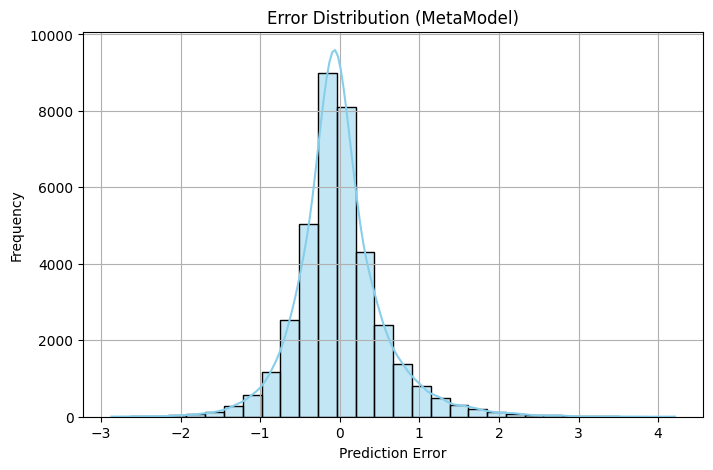

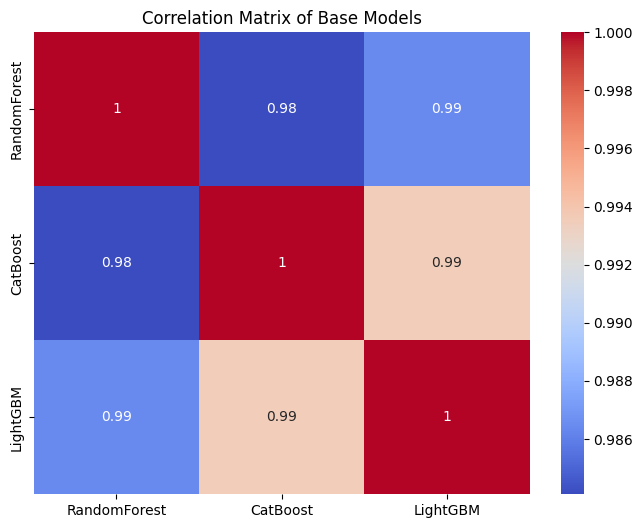

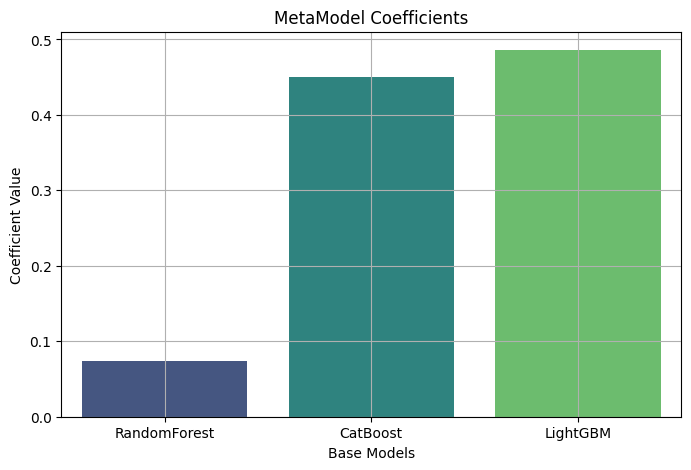

In [35]:
rf_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'n_jobs': -1,
    'max_features': 'sqrt'
}

ctb_params = {
    "random_seed": 42,
    "iterations": 15000,
    "early_stopping_rounds": 1000,
    "use_best_model": True,
    "eval_metric": 'RMSE',
    "verbose": 1000
}

lgbm_params = {
    'n_estimators': 1000,
    'reg_lambda': 0.8435272531761764,
    'reg_alpha': 0.0047770992003183695,
    'colsample_bytree': 0.5,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'max_depth': 100,
    'min_child_samples': 194,
    'num_leaves': 894
}

rf_model = RandomForestRegressor(**rf_params)
catboost_model = ctb.CatBoostRegressor(**ctb_params)
lgbm_model = LGBMRegressor(**lgbm_params)

skf = KFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)

meta_features = []
meta_targets = []
test_meta_features = []

fold_metrics = {
    'mae': [],
    'rmse': [],
    'r2': []
}

def evaluate_fold(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def plot_error_distribution(errors, title):
    plt.figure(figsize=(8, 5))
    sns.histplot(errors, kde=True, bins=30, color='skyblue')
    plt.title(title)
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

def plot_correlation_matrix(predictions, model_names):
    correlation_matrix = np.corrcoef(predictions, rowvar=False)
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, xticklabels=model_names, yticklabels=model_names, cmap="coolwarm")
    plt.title("Correlation Matrix of Base Models")
    plt.show()

def plot_meta_model_coefficients(meta_model, model_names):
    coefficients = meta_model.coef_
    plt.figure(figsize=(8, 5))
    sns.barplot(x=model_names, y=coefficients, palette="viridis")
    plt.title("MetaModel Coefficients")
    plt.ylabel("Coefficient Value")
    plt.xlabel("Base Models")
    plt.grid()
    plt.show()

for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    train_x, val_x = X.iloc[train_index], X.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    rf_model.fit(train_x, train_y)
    rf_preds = rf_model.predict(val_x)

    catboost_model.fit(train_x, train_y, eval_set=(val_x, val_y))
    catboost_preds = catboost_model.predict(val_x)

    lgbm_model.fit(X=train_x, y=train_y, eval_set=[(val_x, val_y)])
    lgbm_preds = lgbm_model.predict(val_x)

    fold_meta_features = np.column_stack([rf_preds, catboost_preds, lgbm_preds])
    meta_features.append(fold_meta_features)
    meta_targets.append(val_y)

    rf_test_preds = rf_model.predict(test)
    ctb_test_preds = catboost_model.predict(test)
    lgbm_test_preds = lgbm_model.predict(test)
    test_meta_features.append(np.column_stack([rf_test_preds, ctb_test_preds, lgbm_test_preds]))

    meta_model = Ridge(alpha=0.5)
    meta_model.fit(fold_meta_features, val_y)
    val_preds = meta_model.predict(fold_meta_features)

    mae, rmse, r2 = evaluate_fold(val_y, val_preds)
    fold_metrics['mae'].append(mae)
    fold_metrics['rmse'].append(rmse)
    fold_metrics['r2'].append(r2)

    print(f"Fold {fold} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Итоговые метрики
mean_mae = np.mean(fold_metrics['mae'])
mean_rmse = np.mean(fold_metrics['rmse'])
mean_r2 = np.mean(fold_metrics['r2'])

print("\nFinal Cross-Validation Metrics:")
print(f"  Mean MAE: {mean_mae:.4f}")
print(f"  Mean RMSE: {mean_rmse:.4f}")
print(f"  Mean R²: {mean_r2:.4f}")

# Объединение мета-признаков и финальная модель
meta_features = np.vstack(meta_features)
meta_targets = np.concatenate(meta_targets)
test_meta_features = np.mean(test_meta_features, axis=0)

final_meta_model = Ridge(alpha=0.5)
final_meta_model.fit(meta_features, meta_targets)
final_preds = final_meta_model.predict(test_meta_features)

# Визуализация распределения ошибок на метауровне
plot_error_distribution(meta_targets - final_meta_model.predict(meta_features), "Error Distribution (MetaModel)")

# Матрица корреляций
model_names = ["RandomForest", "CatBoost", "LightGBM"]
predictions = np.column_stack([rf_model.predict(X), catboost_model.predict(X), lgbm_model.predict(X)])
plot_correlation_matrix(predictions, model_names)

# Анализ коэффициентов метамодели
plot_meta_model_coefficients(final_meta_model, model_names)


In [36]:
columns = ["id"] + ["MedHouseVal"]
df_meta_solution = pd.DataFrame(columns=columns)
df_meta_solution['id'] = range(37137, len(test) + 37137)
df_meta_solution['MedHouseVal'] = final_preds
df_meta_solution.to_csv('ensemble.csv',index=False)